In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.special import erf

pi = np.pi
exp = np.exp
sqrt = np.sqrt
hbar = 1.0546e-34  # reduced Planck constant
options = Options()

In [23]:
Nq = 2  # number of levels in qubit
N1 = 3  # number of levels in resonator 1
N2 = 3  # number of levels in resonator 2

wq = 7e9*2*pi  # qubit frequency
w1 = wq        # resonator 1 frequency
w2 = wq        # resonator 2 frequency
wp = wq        # pump frequency
Delta = wp - wq  # frequency for RWA

kq = 50e3*2*pi  # photon emission frequency of qubit (qubit decay rate)
k1 = 5e3*2*pi   # photon emission frequency of resonator 1 (resonator 1 decay rate)
k2 = 6e6*2*pi   # photon emission frequency of resonator 2 (resonator 2 decay rate)

g1 = 1e6*2*pi  # drive frequency resonator 1, coupling between qubit and resonator 1
g2 = 5e6*2*pi  # drive frequency resonator 2

Ec = 200e6*2*pi  # Anharmonicity

t0 = 0            # start Gaussian pulse Omega
t1 = t0 + 50e-9   # end Gaussian pulse Omega
t2 = t1 + 10e-9   # start square pulse at resonator 1
t3 = t2 + 300e-9  # end square pulse at resonator 1
t4 = t3 + 10e-9   # start square pulse at resonator 2
t5 = t4 + 300e-9  # end square pulse at resonator 2
t6 = t5 + 10e-9   # t0
tg = 10e-9        # Gaussian rise and fall time of square pulse

N_repeat = 1  # number of times to repeat cycle
Q = 3  # number of std's in Gaussian curves, rises and falls

In [24]:
# Convention:
# [qubit, resonator 1, resonator 2]

# Qubit operators
b = tensor(destroy(Nq), qeye(N1), qeye(N2))
nq = b.dag()*b
sx = tensor(sigmax(), qeye(N1), qeye(N2)) # x-projection of qubit level
sy = tensor(sigmay(), qeye(N1), qeye(N2)) # y-projection of qubit level
sz = tensor(sigmaz(), qeye(N1), qeye(N2)) # z-projection of qubit level

# Cavity operators
a1 = tensor(qeye(Nq), destroy(N1), qeye(N2))
a2 = tensor(qeye(Nq), qeye(N1), destroy(N2))
n1 = a1.dag()*a1
n2 = a2.dag()*a2

# Jaynes-Cummings Hamiltonian
Hjc = ( (w1*a1.dag()*a1) 
      + (w2*a2.dag()*a2) 
      + (wq*b.dag()*b) 
      + Ec/2*b.dag()*b.dag()*b*b )

# Coupling Hamiltonians
H1 = g1*(a1*b.dag() + b*a1.dag())
H2 = g2*(a1*b.dag() + b*a2.dag())

# Hamiltonian arguments
H_args = {"t0" : t0, "t1" : t1, "t2" : t2, "t3" : t3, 
          "t4" : t4, "t5" : t5, "t6" : t6, "tg" : tg,
          "g1" : g1, "g2" : g2, "Q"  : Q}

In [44]:
def pump_strength(args):
    t0 = args['t0']
    t1 = args['t1']
    Q  = args['Q']
    tau = t1-t0      # pulse duration
    std = tau/(2*Q)  # standard deviation
    print(tau)
    print(std)
    time = lambda s : Q*sqrt(2)*(s-(t0+0.5*tau))/tau  # t' to pass to scipy.special.erf
    
    Omega = pi/(sqrt(pi)/2*(erf(time(t1)) - erf(time(t0))))
    return Omega
a = pump_strength(H_args)
# Pump Hamiltonian
# Omega = pump_strength(H_args)
Omega = pi/(t1-t0)
H_args['Omega'] = Omega
Hp = Omega/2*(b + b.dag()) - hbar*wp*b.dag()*b  # including rotating frame approximation

5e-08
8.333333333333334e-09


In [26]:
# Collapse operators, losses
cq = sqrt(kq)*b   # qubit
c1 = sqrt(k1)*a1  # resonator 1
c2 = sqrt(k2)*a2  # resonator 2
c_ops = [cq, c1, c2]

# Expectation operators
e_ops = [nq, n1, n2, sx, sy, sz]

In [33]:
def pump(t, args):
    t0 = args['t0']  # start of pulse
    t1 = args['t1']  # end of pulse
    Q  = args['Q']
    Omega = pump_strength(args)  # coupling between qubit and pump field
    
    mu = (t1-t0)/2  # pulse center in time domain
    std = (t1-t0)/(2*Q)  # standard deviation
    top = lambda std : 1/sqrt(2*pi*std**2)  # height of the Gaussian
    scale = Omega/top(std)  # scale factor to set Gaussian height to Omega
    
    confine = np.heaviside((t-t0), 0) - np.heaviside((t-t1), 0)  # entire pulse
    
    pulse = scale*1/(2*pi*std**2)*exp(-(t-mu)**2/(2*std**2))*confine
    return pulse

In [34]:
def square1(t, args):
    t2 = args['t2']  # start of pulse
    t3 = args['t3']  # end of pulse
    tg = args['tg']  # time of Gaussian rise and fall
    g1 = args['g1']  # pulse strength
    Q  = args['Q']
    
    confine = np.heaviside((t-t2), 0) - np.heaviside((t-t3), 0)  # entire pulse
    
    # Rise and fall with Gaussian
    mu = t2+tg  # center of Gaussian
    std = tg/Q  # standard deviation of Gaussian
    gauss = lambda mu : 1/sqrt(2*pi*std**2)*exp(-(t-mu)**2/(2*std**2))  # Gaussian
    top = lambda std : 1/sqrt(2*pi*std**2)  # height of the Gaussian
    scale = g1/top(std)  # scale factor to attach Gaussian to block
    
    
    block = g1*(np.heaviside((t-(t2+tg)), 0) - np.heaviside((t-(t3-tg)), 0))
    rise = scale*gauss(t2+tg) * (1-np.heaviside((t-(t2+tg)), 0))
    fall = scale*gauss(t3-tg) * (np.heaviside((t-(t3-tg)), 0))
    
    pulse = (rise + block + fall)*confine
    return pulse

In [35]:
def square2(t, args):
    t4 = args['t4']  # start of pulse
    t5 = args['t5']  # end of pulse
    tg = args['tg']  # time of Gaussian rise and fall
    g2 = args['g2']  # pulse strength
    Q  = args['Q']
    
    confine = np.heaviside((t-t4), 0) - np.heaviside((t-t5), 0)  # entire pulse
    
    # Rise and fall with Gaussian
    mu = t4+tg  # center of Gaussian
    std = tg/Q  # standard deviation of Gaussian
    gauss = lambda mu : 1/sqrt(2*pi*std**2)*exp(-(t-mu)**2/(2*std**2))  # Gaussian
    top = lambda std : 1/sqrt(2*pi*std**2)  # height of the Gaussian
    scale = g2/top(std)  # scale factor to attach Gaussian to block
    
    
    block = g2*(np.heaviside((t-(t4+tg)), 0) - np.heaviside((t-(t5-tg)), 0))
    rise = scale*gauss(t4+tg) * (1-np.heaviside((t-(t4+tg)), 0))
    fall = scale*gauss(t5-tg) * (np.heaviside((t-(t5-tg)), 0))
    
    pulse = (rise + block + fall)*confine
    return pulse

In [36]:
H = [Hjc, Hp, [H1, square1], [H2, square2]]  # complete Hamiltonian
tlist = np.linspace(0, N_repeat*t6, 1000)  # discrete time steps for which to store the output
psi0 = tensor(basis(Nq,1), basis(N1,0), basis(N2,0))  # initial state
options.nsteps = 1e3  # max number of steps to take for each interval
options.store_states=True

result = mesolve(H, psi0, tlist, c_ops, e_ops=e_ops, args=H_args, options=options)

Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

In [37]:
print(pump_strength(tlist, H_args))

TypeError: pump_strength() takes 1 positional argument but 2 were given

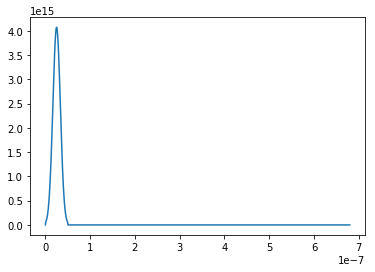

In [38]:
pulse = pump(tlist, H_args) + square1(tlist, H_args) + square2(tlist, H_args)
plt.plot(tlist, pulse)

[ inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf
  inf  inf  inf  inf  inf   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


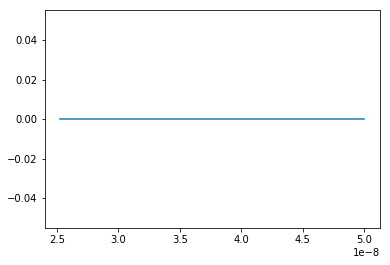

In [41]:
tlist = np.linspace(t0,t1,100)
y = exp(-2*Q**2*(tlist-(t0+0.5*(t1-t0)))/(t1-t0)**2)
print(y)
plt.plot(tlist,y)